In [55]:
import numpy as np
from numba import vectorize
import matplotlib.pyplot as plt
import torch
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj')
from dft3dgpu import dft3d

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-04-27

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4036MB, multi_processor_count=6)


In [57]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

# Defining the fluid properties

In [58]:
# fluid properties
sigma = 1.0
epsilon = 1.0
L = 11.0*sigma
# Temperature and Density 
kT = 2.934
rhob = 0.450

# Defining the functional 


In [59]:
# Test the HS functional 
Ngrid = 64
DFT = dft3d(gridsize=(Ngrid,Ngrid,Ngrid))
DFT.Set_Geometry(L=L)
DFT.Set_FluidProperties(sigma=sigma,epsilon=epsilon)
DFT.Set_Temperature(kT)
DFT.Set_BulkDensity(rhob)

In [60]:
DFT.delta

array([0.171875, 0.171875, 0.171875])

In [61]:
R = np.sqrt(DFT.X**2+DFT.Y**2+DFT.Z**2)
Vext = ljpotential(R,epsilon,sigma)
DFT.Set_External_Potential(Vext)

del R

(-5.5, 5.5, -5.5, 5.5)

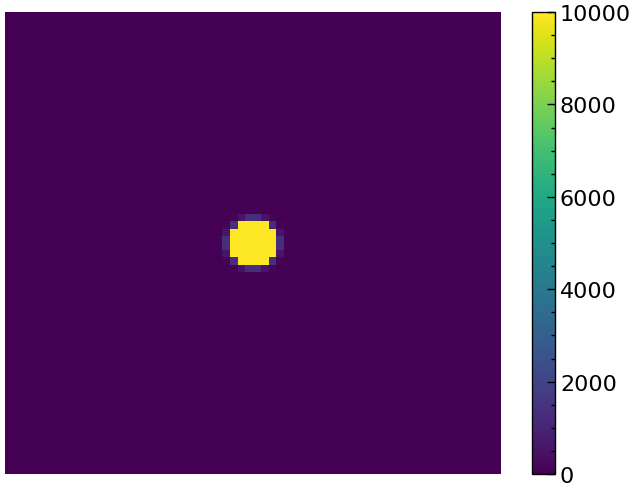

In [62]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis')
plt.colorbar(c)
plt.axis('off')

## Setting the Initial Condition

In [63]:
DFT.Set_InitialCondition()

In [64]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.4515))

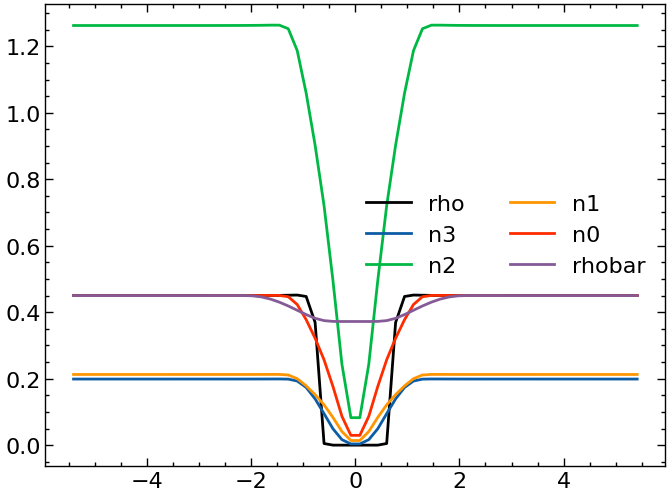

In [65]:
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rho[:,Ngrid//2,Ngrid//2].numpy(),color='k',label='rho')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n3[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n3')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n2[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n2')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n1[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n1')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n0[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n0')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rhobar[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='rhobar')
plt.legend(loc='best',ncols=2)

## Calculate Equilibrium

In [66]:
# DFT.Calculate_Equilibrium(alpha0=0.6,rtol=1e-1,atol=1e-2,max_iter=15,method='picard',logoutput=True)
DFT.Calculate_Equilibrium(alpha0=0.25,dt=0.5,rtol=1e-3,atol=1e-4,method='fire',logoutput=True)

0 -2376.122 754032.6
1 -2419.2666 10425.524
2 -2418.5486 20386.746
3 -2419.5093 6354.459
4 -2419.3572 11148.627
5 -2419.602 2215.901
6 -2419.4963 7603.308
7 -2419.6025 1946.7899
8 -2419.5422 5837.9536
9 -2419.5952 2608.6643
10 -2419.3735 10369.2295
11 -2419.5503 5731.794
12 -2419.5254 6364.606
13 -2419.5435 5538.759
14 -2419.5754 4201.9204
15 -2419.6008 2253.7383
16 -2419.6006 2380.9717
17 -2419.604 2064.463
18 -2419.6062 1645.5201
19 -2419.6094 1146.5801
20 -2419.61 998.876
21 -2419.6094 924.26447
22 -2419.6108 516.75476
23 -2419.6125 144.99445
24 -2419.6116 117.71389
25 -2419.611 95.3892
26 -2419.612 60.911163
27 -2419.6123 25.153633
28 -2419.6123 27.328428
29 -2419.6116 20.24489
30 -2419.6118 18.748564
31 -2419.612 16.355389
32 -2419.6118 13.23457
33 -2419.6116 9.539322
34 -2419.6118 5.4366827
35 -2419.6118 1.478023
36 -2419.6118 2.8289227
37 -2419.6118 1.9808629
38 -2419.6123 1.9533942
39 -2419.612 1.8912408
40 -2419.6118 1.7967637
41 -2419.6118 1.7208707
42 -2419.6118 1.574881
43 

In [67]:
DFT.Niter

46

In [68]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.7234))

In [69]:
DFT.Omega

tensor(-2419.6118)

(-5.5, 5.5, -5.5, 5.5)

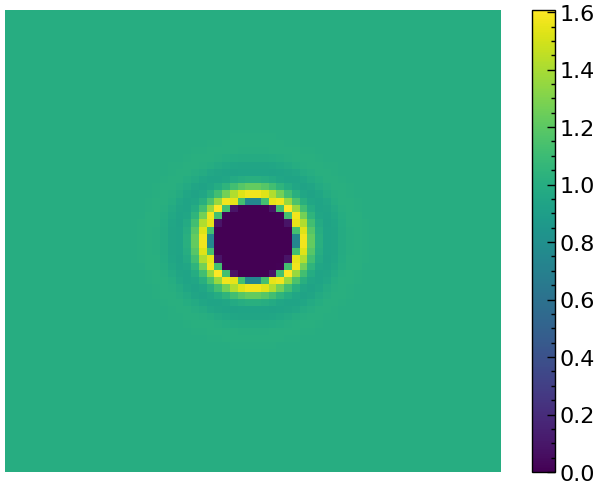

In [70]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.rho[:,:,Ngrid//2].numpy()/rhob, cmap='viridis')
plt.colorbar(c)
plt.axis('off')

## Plotting g(r)

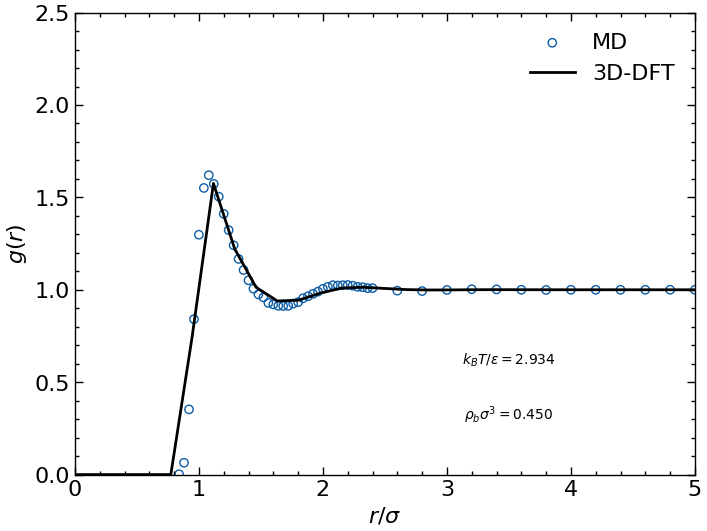

In [71]:
import pandas as pd
df = pd.read_excel('data/MC/MCdata-radialdistribution-lennardjones-Verlet1968.xls',sheet_name='rhob=0.450')
plt.scatter(df['r'],df['KT=2.934'],marker='o',edgecolors='C0',facecolors='none',label='MD')
# plt.plot(dft.r[90:],np.exp(-dft.beta*dft.Vext[90:]),'--',color='grey',label=r'no corr.')
plt.plot(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob,'-',color='k',label=r'3D-DFT')
plt.xlim(0.0,5)
plt.ylim(0,2.5)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.text(3.5,0.6,r'$k_B T/\epsilon = 2.934$',ha='center')
plt.text(3.5,0.3,r'$\rho_b \sigma^3 = 0.450$',ha='center')
plt.legend(loc='upper right',ncol=1)

In [72]:
np.save('radialdistribution-3D-Ngrid='+str(Ngrid)+'.npy',(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob))